In [5]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
import json
import os
import multiprocessing
cpu_count = multiprocessing.cpu_count()

import xgboost as xgb

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
from pprint import pprint
import sys
from sklearn.utils import resample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns



def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y

In [6]:

def id_exists(unique_users, uid):
    if uid in unique_users:
        return True
    return False

def filter_id_list(unique_users, value):
        return list(filter(lambda uid: id_exists(unique_users,uid), value))
    

def network_simulation_init(users, simulation_start_min):
    current_time = simulation_start_min
    network_simulation = pd.DataFrame(columns= ['id','time_lapsed','favourites_count','followers_count','friends_count',
                                'listed_count','statuses_count','source_candidates','source_index','seed_index','generation',
                                 'time_since_seed','user_created_days','normalized_statuses_count','normalized_followers_count',
                                 'normalized_favourites_count','normalized_listed_count','normalized_friends_count'])

    network_simulation['id']=users['id']
    network_simulation['favourites_count']=users['favourites_count']
    network_simulation['followers_count']=users['followers_count']
    network_simulation['friends_count']=users['friends_count']
    network_simulation['listed_count']=users['listed_count']
    network_simulation['statuses_count']=users['statuses_count']
    network_simulation['user_created_days']=users['user_created_days']
    network_simulation['normalized_statuses_count']=users['normalized_statuses_count']
    network_simulation['normalized_followers_count']=users['normalized_followers_count']
    network_simulation['normalized_favourites_count']=users['normalized_favourites_count']
    network_simulation['normalized_listed_count']=users['normalized_listed_count']
    network_simulation['normalized_friends_count']=users['normalized_friends_count']
#     network_simulation['followers_list'] =users['followers_json'] 
#     network_simulation['friends_list'] =users['friends_json']
    network_simulation['time_lapsed'] = users['time_lapsed'].apply(lambda x: x if x <= current_time else None)
    network_simulation['source_index'] = users.apply(lambda x: x['source_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['seed_index'] = users.apply(lambda x: x['seed_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['generation'] = users.apply(lambda x: x['generation'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['time_since_seed'] = users.apply(lambda x: x['time_since_seed'] if x['time_lapsed'] <= current_time else None,axis=1)

    return network_simulation


def network_simulation_merge_friends_list(network_simulation, path_of_friends_list):

    friends = load_pickle_file(path_of_friends_list)
    friends_list = pd.DataFrame(columns=['id'], data=friends.keys())
    friends_list["friends_list"] = ''
    for i in range (0, len(friends)):
        friends_list["friends_list"][i]= friends.get(friends_list["id"][i])
    friends_list.reset_index(drop =True , inplace =True)
    return pd.merge(network_simulation,friends_list, on='id', how='left')
    

def network_simulation_merge_followers_list(network_simulation, path_of_followers_list):
    followers = load_pickle_file(path_of_followers_list)
    followers_list = pd.DataFrame(columns=['id'], data=followers.keys())
    followers_list["followers_list"] = ''
    for i in range (0, len(followers)):
        followers_list["followers_list"][i]= followers.get(followers_list["id"][i])
    # print(friends_list.get(942362499923566592 ))
    followers_list.reset_index(drop =True , inplace =True)
    # print(followers_list)


    return pd.merge(network_simulation,followers_list,on='id',how='left')
    
#     print(network_simulation)

# construct and extract features dataset based on the information in users and  network_simulation data.  
# current_min is number of minutes since the first seed, and all imformation before this time point is known.
# This function will only generate features for users between start_index and end_index. If current_features is not None, 
# the function will update the features for users between start_index and end_index.
def construct_features(users, network_simulation, start_index, end_index, current_min, current_features=None):
    
    current_time = current_min   
    features = current_features
    in_degree = list(users.friends_count)
    out_degree = list(users.followers_count)
    degree = (users.friends_count+users.followers_count).tolist()
    if current_features is None:
        features = {
            #Columns which are added for simulation, but they are not used as features for model prediction
            'user_id':[],
            'infected_status':[],
            'infection_time':[],
            'followers_list':[],

            #Columns used as features for model prediction   33
            'UsM_deltaDays': [],
            'UsM_statusesCount': [],
            'UsM_followersCount': [],
            'UsM_favouritesCount': [],
            'UsM_friendsCount': [],
            'UsM_listedCount': [],
            'UsM_normalizedUserStatusesCount': [],
            'UsM_normalizedUserFollowersCount': [],
            'UsM_normalizedUserFavouritesCount': [],
            'UsM_normalizedUserListedCount': [],
            'UsM_normalizedUserFriendsCount': [],          
            'UsM_deltaDays0': [],
            'UsM_statusesCount0': [],
            'UsM_followersCount0': [],
            'UsM_favouritesCount0': [],
            'UsM_friendsCount0': [],
            'UsM_listedCount0': [],
            'UsM_normalizedUserStatusesCount0': [],
            'UsM_normalizedUserFollowersCount0': [],
            'UsM_normalizedUserFavouritesCount0': [],
            'UsM_normalizedUserListedCount0': [],
            'UsM_normalizedUserFriendsCount0': [],
            'UsM_deltaDays-1': [],
            'UsM_statusesCount-1': [],
            'UsM_followersCount-1': [],
            'UsM_favouritesCount-1': [],
            'UsM_friendsCount-1': [],
            'UsM_listedCount-1': [],
            'UsM_normalizedUserStatusesCount-1': [],
            'UsM_normalizedUserFollowersCount-1': [],
            'UsM_normalizedUserFavouritesCount-1': [],
            'UsM_normalizedUserListedCount-1': [],
            'UsM_normalizedUserFriendsCount-1': [],
            # TwM: Tweet metadata   5
            'TwM_t0': [],
            'TwM_tSeed0': [],
            'TwM_t-1': [],
            'TwM_tSeed-1': [],
            'TwM_tCurrent': [],
            # Nw: Network0    15
            'Nw_degree': [],
            'Nw_inDegree': [],
            'Nw_outDegree': [],
            'Nw_degree0': [],
            'Nw_inDegree0': [],
            'Nw_outDegree0': [],
            'Nw_degree-1': [],
            'Nw_inDegree-1': [],
            'Nw_outDegree-1': [],
            'Nw_degreeSeed0': [],
            'Nw_inDegreeSeed0': [],
            'Nw_outDegreeSeed0': [],
            'Nw_degreeSeed-1': [],
            'Nw_inDegreeSeed-1': [],
            'Nw_outDegreeSeed-1': [],
            # SNw: Spreading Network   20
            'SNw_nFriendsInfected': [],
            'SNw_friendsInfectedRatio': [],
            'SNw_generation0': [],
            'SNw_generation-1': [],
            'SNw_timeSinceSeed0': [],
            'SNw_timeSinceSeed-1': [],
            'SNw_totalNodesInfected': [],
            'SNw_nodeInfectedCentrality': [],
            'SNw_totalInDegree': [],
            'SNw_totalOutDegree': [],
            'SNw_inDegreeCentrality': [],
            'SNw_inDegreeCentrality0': [],
            'SNw_inDegreeCentrality-1': [],
            'SNw_outDegreeCentrality': [],
            'SNw_outDegreeCentrality0': [],
            'SNw_outDegreeCentrality-1': [],
            'SNw_inDegreeCentralitySeed0':[],
            'SNw_outDegreeCentralitySeed0':[],
            'SNw_inDegreeCentralitySeed-1':[],
            'SNw_outDegreeCentralitySeed-1':[],
            # Stat: Statistical  15
            'Stat_average_kOut': [],
            'Stat_average_t': [],
            'Stat_average_deltaDays': [],
            'Stat_average_statusesCount': [],
            'Stat_average_followersCount': [],
            'Stat_average_favouritesCount': [],
            'Stat_average_friendsCount': [],
            'Stat_average_listedCount': [],
            'Stat_average_normalizedUserStatusesCount': [],
            'Stat_average_normalizedUserFollowersCount': [],
            'Stat_average_normalizedUserFavouritesCount': [],
            'Stat_average_normalizedUserListedCount': [],
            'Stat_average_normalizedUserFriendsCount': [],                
            'Stat_max_kOut': [],
            'Stat_min_kOut': []

        }

        with tqdm(total=len(list(users[start_index: end_index].iterrows()))) as pbar: 
            for index, user_row in users[start_index: end_index].iterrows():
                source_candidates = sorted(user_row['source_candidates'])
                features['user_id'].append(user_row['id'])
                features['infected_status'].append(False)
                features['infection_time'].append(None)
                #print(f"user_row['followers_list']:{user_row['followers_list']}")
                features['followers_list'].append(user_row['followers_json'])
                #print("b")
                features['UsM_deltaDays'].append(user_row['user_created_days'])
                features['UsM_statusesCount'].append(user_row['statuses_count'])
                features['UsM_followersCount'].append(user_row['followers_count'])
                features['UsM_favouritesCount'].append(user_row['favourites_count'])
                features['UsM_friendsCount'].append(user_row['friends_count'])
                features['UsM_listedCount'].append(user_row['listed_count'])
                features['UsM_normalizedUserStatusesCount'].append(user_row['normalized_statuses_count'])
                features['UsM_normalizedUserFollowersCount'].append(user_row['normalized_followers_count'])
                features['UsM_normalizedUserFavouritesCount'].append(user_row['normalized_favourites_count'])
                features['UsM_normalizedUserListedCount'].append(user_row['normalized_listed_count'])
                features['UsM_normalizedUserFriendsCount'].append(user_row['normalized_friends_count'])
                if user_row['time_lapsed'] <= current_time:

                    features['infected_status'][-1] = True
                    features['infection_time'][-1] = user_row['time_lapsed']

                    network_simulation.loc[index,'time_lapsed'] = user_row['time_lapsed']

                    network_simulation.loc[index,'source_index'] = user_row['source_index']
                    network_simulation.loc[index,'seed_index'] = user_row['seed_index']
                    network_simulation.loc[index, 'generation'] = user_row['generation']
                    network_simulation.loc[index, 'time_since_seed'] = user_row['time_since_seed']
                if isinstance(source_candidates, list):
                    sources = network_simulation.loc[source_candidates]
                    sources_dataframe = sources[sources['time_lapsed'] <= current_time]
    #                 if user_row['time_lapsed'] > current_time:
    #                     sources_dataframe = sources[sources['time_lapsed'] <= current_time]
    #                 else:
    #                      sources_dataframe = sources[sources['time_lapsed'] <= user_row['time_lapsed']]
                    sources = sources_dataframe.index.tolist()
                else:
                    sources = []
                #sources = [x for x in source_candidates if users.loc[x,'time_lapsed'] <= current_time]
                #print(f'sources:{sources}')
                if len(sources) > 0:

                    # Assign the values here to save computation
                    first_source_index = source_candidates[0]
                    first_source_row = users.loc[first_source_index]
                    first_source_seed_row = users.loc[first_source_row['seed_index']]

                    inDegreeList = sources_dataframe.friends_count.tolist()
                    outDegreeList = sources_dataframe.followers_count.tolist()
                    degreeList = [x + y for x, y in zip(inDegreeList, outDegreeList)]

                    s_ind = sources_dataframe.friends_count
                    s_outd = sources_dataframe.followers_count
                    outDegreeList = s_outd.tolist()
                    inDegreeList = s_ind.tolist()
                    degreeList = (s_ind + s_outd).tolist()

                    #degreeList = list(users.loc[i, 'followers_count'] + users.loc[i, 'friends_count']  for i in sources)
                    current_time_series = pd.Series([current_time] * len(sources))
                    time_lapsed_series = sources_dataframe.time_lapsed
                    timeList = (current_time_series - time_lapsed_series).tolist()


                    last_source_index = sources[-1]
                    last_source_row = network_simulation.loc[last_source_index]
                    last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]

                    usr_index = index

    #                 if user_row['time_lapsed'] <= current_time:

    #                     features['infected_status'][-1] = True
    #                     features['infection_time'][-1] = user_row['time_lapsed']

    #                     network_simulation.loc[usr_index,'time_lapsed'] = user_row['time_lapsed']

    #                     network_simulation.loc[usr_index,'source_index'] = user_row['source_index']
    #                     network_simulation.loc[usr_index,'seed_index'] = user_row['seed_index']
    #                     network_simulation.loc[usr_index, 'generation'] = user_row['generation']
    #                     network_simulation.loc[usr_index, 'time_since_seed'] = user_row['time_since_seed']


                    network_simulation.at[usr_index,'source_candidates'] = sources

                    # UsM: User metadata

                    features['UsM_deltaDays0'].append(first_source_row.user_created_days)
                    features['UsM_statusesCount0'].append(first_source_row.statuses_count)
                    features['UsM_followersCount0'].append(first_source_row.followers_count)
                    features['UsM_favouritesCount0'].append(first_source_row.favourites_count)
                    features['UsM_friendsCount0'].append(first_source_row.friends_count)
                    features['UsM_listedCount0'].append(first_source_row.listed_count)
                    features['UsM_normalizedUserStatusesCount0'].append(first_source_row.normalized_statuses_count)
                    features['UsM_normalizedUserFollowersCount0'].append(first_source_row.normalized_followers_count)
                    features['UsM_normalizedUserFavouritesCount0'].append(first_source_row.normalized_favourites_count)
                    features['UsM_normalizedUserListedCount0'].append(first_source_row.normalized_listed_count)
                    features['UsM_normalizedUserFriendsCount0'].append(first_source_row.normalized_friends_count)
                    features['UsM_deltaDays-1'].append(last_source_row.user_created_days)
                    features['UsM_statusesCount-1'].append(last_source_row.statuses_count)
                    features['UsM_followersCount-1'].append(last_source_row.followers_count)
                    features['UsM_favouritesCount-1'].append(last_source_row.favourites_count)
                    features['UsM_friendsCount-1'].append(last_source_row.friends_count)
                    features['UsM_listedCount-1'].append(last_source_row.listed_count)
                    features['UsM_normalizedUserStatusesCount-1'].append(last_source_row.normalized_statuses_count)
                    features['UsM_normalizedUserFollowersCount-1'].append(last_source_row.normalized_followers_count)
                    features['UsM_normalizedUserFavouritesCount-1'].append(last_source_row.normalized_favourites_count)
                    features['UsM_normalizedUserListedCount-1'].append(last_source_row.normalized_listed_count)
                    features['UsM_normalizedUserFriendsCount-1'].append(last_source_row.normalized_friends_count)
                    # TwM: Tweet metadata
                    features['TwM_t0'].append(round(timeList[0], 1))
                    features['TwM_tSeed0'].append(round(current_time - first_source_seed_row['time_lapsed'], 1))
                    features['TwM_t-1'].append(round(timeList[-1], 1))
                    features['TwM_tSeed-1'].append(round(current_time - last_source_seed_row['time_lapsed'], 1))
                    features['TwM_tCurrent'].append(current_time)
                    # Nw: Network
                    features['Nw_degree'].append(degree[index])
                    features['Nw_inDegree'].append(in_degree[index])
                    features['Nw_outDegree'].append(out_degree[index])
                    features['Nw_degree0'].append(degree[first_source_index])
                    features['Nw_inDegree0'].append(in_degree[first_source_index])
                    features['Nw_outDegree0'].append(out_degree[first_source_index])
                    features['Nw_degree-1'].append(degree[last_source_index])
                    features['Nw_inDegree-1'].append(in_degree[last_source_index])
                    features['Nw_outDegree-1'].append(out_degree[last_source_index])
                    features['Nw_degreeSeed0'].append(degree[int(first_source_row['seed_index'])])
                    features['Nw_inDegreeSeed0'].append(in_degree[int(first_source_row['seed_index'])])
                    features['Nw_outDegreeSeed0'].append(out_degree[int(first_source_row['seed_index'])])
                    features['Nw_degreeSeed-1'].append(degree[int(last_source_row['seed_index'])])
                    features['Nw_inDegreeSeed-1'].append(in_degree[int(last_source_row['seed_index'])])
                    features['Nw_outDegreeSeed-1'].append(out_degree[int(last_source_row['seed_index'])])
                    # SNw: Spreading Network
                    features['SNw_nFriendsInfected'].append(len(sources))
                    features['SNw_friendsInfectedRatio'].append(safe_division(len(sources), user_row['friends_count']))
                    features['SNw_generation0'].append(first_source_row['generation'])
                    features['SNw_generation-1'].append(last_source_row['generation'])
                    features['SNw_timeSinceSeed0'].append(first_source_row['time_since_seed'])
                    features['SNw_timeSinceSeed-1'].append(last_source_row['time_since_seed'])

                    infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
                    total_nodes_infected = infected_dataframe.shape[0]
                    total_in_degree = sum(infected_dataframe.friends_count)
                    total_out_degree = sum(infected_dataframe.followers_count)

                    features['SNw_totalNodesInfected'].append(total_nodes_infected)
                    features['SNw_nodeInfectedCentrality'].append(len(sources)/total_nodes_infected)
                    features['SNw_totalInDegree'].append(total_in_degree)
                    features['SNw_totalOutDegree'].append(total_out_degree)
                    features['SNw_inDegreeCentrality'].append(in_degree[index]/total_in_degree)
                    features['SNw_inDegreeCentrality0'].append(in_degree[first_source_index]/total_in_degree)
                    features['SNw_inDegreeCentrality-1'].append(in_degree[last_source_index]/total_in_degree)
                    features['SNw_outDegreeCentrality'].append(out_degree[index]/total_out_degree)
                    features['SNw_outDegreeCentrality0'].append(out_degree[first_source_index]/total_out_degree)
                    features['SNw_outDegreeCentrality-1'].append(out_degree[last_source_index]/total_out_degree)
                    features['SNw_inDegreeCentralitySeed0'].append(in_degree[int(first_source_row['seed_index'])]/total_in_degree)
                    features['SNw_outDegreeCentralitySeed0'].append(out_degree[int(first_source_row['seed_index'])]/total_out_degree)
                    features['SNw_inDegreeCentralitySeed-1'].append(in_degree[int(last_source_row['seed_index'])]/total_in_degree)
                    features['SNw_outDegreeCentralitySeed-1'].append(out_degree[int(last_source_row['seed_index'])]/total_out_degree)
                    # Stat: Statistical
                    features['Stat_average_kOut'].append(round(mean(degreeList), 1))
                    features['Stat_average_t'].append(round(mean(timeList), 1))
                    features['Stat_average_deltaDays'].append(sources_dataframe.user_created_days.mean())
                    features['Stat_average_statusesCount'].append(sources_dataframe.statuses_count.mean())
                    features['Stat_average_followersCount'].append(sources_dataframe.followers_count.mean())
                    features['Stat_average_favouritesCount'].append(sources_dataframe.favourites_count.mean())
                    features['Stat_average_friendsCount'].append(sources_dataframe.friends_count.mean())
                    features['Stat_average_listedCount'].append(sources_dataframe.listed_count.mean())
                    features['Stat_average_normalizedUserStatusesCount'].append(sources_dataframe.normalized_statuses_count.mean())
                    features['Stat_average_normalizedUserFollowersCount'].append(sources_dataframe.normalized_followers_count.mean())
                    features['Stat_average_normalizedUserFavouritesCount'].append(sources_dataframe.normalized_favourites_count.mean())
                    features['Stat_average_normalizedUserListedCount'].append(sources_dataframe.normalized_listed_count.mean())
                    features['Stat_average_normalizedUserFriendsCount'].append(sources_dataframe.normalized_friends_count.mean())
                    features['Stat_max_kOut'].append(max(degreeList))
                    features['Stat_min_kOut'].append(min(degreeList))
                else:
                    features['UsM_deltaDays0'].append(None)
                    features['UsM_statusesCount0'].append(None)
                    features['UsM_followersCount0'].append(None)
                    features['UsM_favouritesCount0'].append(None)
                    features['UsM_friendsCount0'].append(None)
                    features['UsM_listedCount0'].append(None)
                    features['UsM_normalizedUserStatusesCount0'].append(None)
                    features['UsM_normalizedUserFollowersCount0'].append(None)
                    features['UsM_normalizedUserFavouritesCount0'].append(None)
                    features['UsM_normalizedUserListedCount0'].append(None)
                    features['UsM_normalizedUserFriendsCount0'].append(None)
                    features['UsM_deltaDays-1'].append(None)
                    features['UsM_statusesCount-1'].append(None)
                    features['UsM_followersCount-1'].append(None)
                    features['UsM_favouritesCount-1'].append(None)
                    features['UsM_friendsCount-1'].append(None)
                    features['UsM_listedCount-1'].append(None)
                    features['UsM_normalizedUserStatusesCount-1'].append(None)
                    features['UsM_normalizedUserFollowersCount-1'].append(None)
                    features['UsM_normalizedUserFavouritesCount-1'].append(None)
                    features['UsM_normalizedUserListedCount-1'].append(None)
                    features['UsM_normalizedUserFriendsCount-1'].append(None)
                    # TwM: Tweet metadata
                    features['TwM_t0'].append(None)
                    features['TwM_tSeed0'].append(None)
                    features['TwM_t-1'].append(None)
                    features['TwM_tSeed-1'].append(None)
                    features['TwM_tCurrent'].append(None)
                    # Nw: Network
                    features['Nw_degree'].append(None)
                    features['Nw_inDegree'].append(None)
                    features['Nw_outDegree'].append(None)
                    features['Nw_degree0'].append(None)
                    features['Nw_inDegree0'].append(None)
                    features['Nw_outDegree0'].append(None)
                    features['Nw_degree-1'].append(None)
                    features['Nw_inDegree-1'].append(None)
                    features['Nw_outDegree-1'].append(None)
                    features['Nw_degreeSeed0'].append(None)
                    features['Nw_inDegreeSeed0'].append(None)
                    features['Nw_outDegreeSeed0'].append(None)
                    features['Nw_degreeSeed-1'].append(None)
                    features['Nw_inDegreeSeed-1'].append(None)
                    features['Nw_outDegreeSeed-1'].append(None)
                    # SNw: Spreading Network
                    features['SNw_nFriendsInfected'].append(0)
                    features['SNw_friendsInfectedRatio'].append(None)
                    features['SNw_generation0'].append(None)
                    features['SNw_generation-1'].append(None)
                    features['SNw_timeSinceSeed0'].append(None)
                    features['SNw_timeSinceSeed-1'].append(None)
                    features['SNw_totalNodesInfected'].append(None)
                    features['SNw_nodeInfectedCentrality'].append(None)
                    features['SNw_totalInDegree'].append(None)
                    features['SNw_totalOutDegree'].append(None)
                    features['SNw_inDegreeCentrality'].append(None)
                    features['SNw_inDegreeCentrality0'].append(None)
                    features['SNw_inDegreeCentrality-1'].append(None)
                    features['SNw_outDegreeCentrality'].append(None)
                    features['SNw_outDegreeCentrality0'].append(None)
                    features['SNw_outDegreeCentrality-1'].append(None)
                    features['SNw_inDegreeCentralitySeed0'].append(None)
                    features['SNw_outDegreeCentralitySeed0'].append(None)
                    features['SNw_inDegreeCentralitySeed-1'].append(None)
                    features['SNw_outDegreeCentralitySeed-1'].append(None)
                    # Stat: Statistical
                    features['Stat_average_kOut'].append(None)
                    features['Stat_average_t'].append(None)
                    features['Stat_average_deltaDays'].append(None)
                    features['Stat_average_statusesCount'].append(None)
                    features['Stat_average_followersCount'].append(None)
                    features['Stat_average_favouritesCount'].append(None)
                    features['Stat_average_friendsCount'].append(None)
                    features['Stat_average_listedCount'].append(None)
                    features['Stat_average_normalizedUserStatusesCount'].append(None)
                    features['Stat_average_normalizedUserFollowersCount'].append(None)
                    features['Stat_average_normalizedUserFavouritesCount'].append(None)
                    features['Stat_average_normalizedUserListedCount'].append(None)
                    features['Stat_average_normalizedUserFriendsCount'].append(None)
                    features['Stat_max_kOut'].append(None)
                    features['Stat_min_kOut'].append(None)

                pbar.update(1)
    else:
         with tqdm(total=len(list(users[start_index: end_index].iterrows()))) as pbar: 
            for index, user_row in users[start_index: end_index].iterrows():
                source_candidates = sorted(user_row['source_candidates'])
                if user_row['time_lapsed'] <= current_time:

                    features.at[index,'infected_status'] = True
                    features.at[index,'infection_time'] = user_row['time_lapsed']

                    network_simulation.loc[index,'time_lapsed'] = user_row['time_lapsed']

                    network_simulation.loc[index,'source_index'] = user_row['source_index']
                    network_simulation.loc[index,'seed_index'] = user_row['seed_index']
                    network_simulation.loc[index, 'generation'] = user_row['generation']
                    network_simulation.loc[index, 'time_since_seed'] = user_row['time_since_seed']
                if isinstance(source_candidates, list):
                    sources = network_simulation.loc[source_candidates]
                    sources_dataframe = sources[sources['time_lapsed'] <= current_time]
    #                 if user_row['time_lapsed'] > current_time:
    #                     sources_dataframe = sources[sources['time_lapsed'] <= current_time]
    #                 else:
    #                      sources_dataframe = sources[sources['time_lapsed'] <= user_row['time_lapsed']]
                    sources = sources_dataframe.index.tolist()
                else:
                    sources = []
                #sources = [x for x in source_candidates if users.loc[x,'time_lapsed'] <= current_time]
                #print(f'sources:{sources}')
                if len(sources) > 0:

                    # Assign the values here to save computation
                    first_source_index = source_candidates[0]
                    first_source_row = users.loc[first_source_index]
                    first_source_seed_row = users.loc[first_source_row['seed_index']]

                    inDegreeList = sources_dataframe.friends_count.tolist()
                    outDegreeList = sources_dataframe.followers_count.tolist()
                    degreeList = [x + y for x, y in zip(inDegreeList, outDegreeList)]

                    s_ind = sources_dataframe.friends_count
                    s_outd = sources_dataframe.followers_count
                    outDegreeList = s_outd.tolist()
                    inDegreeList = s_ind.tolist()
                    degreeList = (s_ind + s_outd).tolist()

                    #degreeList = list(users.loc[i, 'followers_count'] + users.loc[i, 'friends_count']  for i in sources)
                    current_time_series = pd.Series([current_time] * len(sources))
                    time_lapsed_series = sources_dataframe.time_lapsed
                    timeList = (current_time_series - time_lapsed_series).tolist()


                    last_source_index = sources[-1]
                    last_source_row = network_simulation.loc[last_source_index]
                    last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]

                    usr_index = index

    #                 if user_row['time_lapsed'] <= current_time:

    #                     features['infected_status'][-1] = True
    #                     features['infection_time'][-1] = user_row['time_lapsed']

    #                     network_simulation.loc[usr_index,'time_lapsed'] = user_row['time_lapsed']

    #                     network_simulation.loc[usr_index,'source_index'] = user_row['source_index']
    #                     network_simulation.loc[usr_index,'seed_index'] = user_row['seed_index']
    #                     network_simulation.loc[usr_index, 'generation'] = user_row['generation']
    #                     network_simulation.loc[usr_index, 'time_since_seed'] = user_row['time_since_seed']


                    network_simulation.at[usr_index,'source_candidates'] = sources

                    # UsM: User metadata

                    features.at[index,'UsM_deltaDays0'] = first_source_row.user_created_days
                    features.at[index,'UsM_statusesCount0'] = first_source_row.statuses_count
                    features.at[index,'UsM_followersCount0'] = first_source_row.followers_count
                    features.at[index,'UsM_favouritesCount0'] = first_source_row.favourites_count
                    features.at[index,'UsM_friendsCount0'] = first_source_row.friends_count
                    features.at[index,'UsM_listedCount0'] = first_source_row.listed_count
                    features.at[index,'UsM_normalizedUserStatusesCount0'] = first_source_row.normalized_statuses_count
                    features.at[index,'UsM_normalizedUserFollowersCount0'] = first_source_row.normalized_followers_count
                    features.at[index,'UsM_normalizedUserFavouritesCount0'] = first_source_row.normalized_favourites_count
                    features.at[index,'UsM_normalizedUserListedCount0'] = first_source_row.normalized_listed_count
                    features.at[index,'UsM_normalizedUserFriendsCount0'] = first_source_row.normalized_friends_count
                    features.at[index,'UsM_deltaDays-1'] = last_source_row.user_created_days
                    features.at[index,'UsM_statusesCount-1'] = last_source_row.statuses_count
                    features.at[index,'UsM_followersCount-1'] = last_source_row.followers_count
                    features.at[index,'UsM_favouritesCount-1'] = last_source_row.favourites_count
                    features.at[index,'UsM_friendsCount-1'] = last_source_row.friends_count
                    features.at[index,'UsM_listedCount-1'] = last_source_row.listed_count
                    features.at[index,'UsM_normalizedUserStatusesCount-1'] = last_source_row.normalized_statuses_count
                    features.at[index,'UsM_normalizedUserFollowersCount-1'] = last_source_row.normalized_followers_count
                    features.at[index,'UsM_normalizedUserFavouritesCount-1'] = last_source_row.normalized_favourites_count
                    features.at[index,'UsM_normalizedUserListedCount-1'] = last_source_row.normalized_listed_count
                    features.at[index,'UsM_normalizedUserFriendsCount-1'] = last_source_row.normalized_friends_count
                    # TwM: Tweet metadata
                    features.at[index,'TwM_t0'] = round(timeList[0], 1)
                    features.at[index,'TwM_tSeed0'] = round(current_time - first_source_seed_row['time_lapsed'], 1)
                    features.at[index,'TwM_t-1'] = round(timeList[-1], 1)
                    features.at[index,'TwM_tSeed-1'] = round(current_time - last_source_seed_row['time_lapsed'], 1)
                    features.at[index,'TwM_tCurrent'] = current_time
                    # Nw: Network
                    features.at[index,'Nw_degree'] = degree[index]
                    features.at[index,'Nw_inDegree'] = in_degree[index]
                    features.at[index,'Nw_outDegree'] = out_degree[index]
                    features.at[index,'Nw_degree0'] = degree[first_source_index]
                    features.at[index,'Nw_inDegree0'] = in_degree[first_source_index]
                    features.at[index,'Nw_outDegree0'] = out_degree[first_source_index]
                    features.at[index,'Nw_degree-1'] = degree[last_source_index]
                    features.at[index,'Nw_inDegree-1'] = in_degree[last_source_index]
                    features.at[index,'Nw_outDegree-1'] = out_degree[last_source_index]
                    features.at[index,'Nw_degreeSeed0'] = degree[int(first_source_row['seed_index'])]
                    features.at[index,'Nw_inDegreeSeed0'] = in_degree[int(first_source_row['seed_index'])]
                    features.at[index,'Nw_outDegreeSeed0'] = out_degree[int(first_source_row['seed_index'])]
                    features.at[index,'Nw_degreeSeed-1'] = degree[int(last_source_row['seed_index'])]
                    features.at[index,'Nw_inDegreeSeed-1'] = in_degree[int(last_source_row['seed_index'])]
                    features.at[index,'Nw_outDegreeSeed-1'] = out_degree[int(last_source_row['seed_index'])]
                    # SNw: Spreading Network
                    features.at[index,'SNw_nFriendsInfected'] = len(sources)
                    features.at[index,'SNw_friendsInfectedRatio'] = safe_division(len(sources), user_row['friends_count'])
                    features.at[index,'SNw_generation0'] = first_source_row['generation']
                    features.at[index,'SNw_generation-1'] = last_source_row['generation']
                    features.at[index,'SNw_timeSinceSeed0'] = first_source_row['time_since_seed']
                    features.at[index,'SNw_timeSinceSeed-1'] = last_source_row['time_since_seed']

                    infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
                    total_nodes_infected = infected_dataframe.shape[0]
                    total_in_degree = sum(infected_dataframe.friends_count)
                    total_out_degree = sum(infected_dataframe.followers_count)

                    features.at[index,'SNw_totalNodesInfected'] = total_nodes_infected
                    features.at[index,'SNw_nodeInfectedCentrality'] = len(sources)/total_nodes_infected
                    features.at[index,'SNw_totalInDegree'] = total_in_degree
                    features.at[index,'SNw_totalOutDegree'] = total_out_degree
                    features.at[index,'SNw_inDegreeCentrality'] = in_degree[index]/total_in_degree
                    features.at[index,'SNw_inDegreeCentrality0'] = in_degree[first_source_index]/total_in_degree
                    features.at[index,'SNw_inDegreeCentrality-1'] = in_degree[last_source_index]/total_in_degree
                    features.at[index,'SNw_outDegreeCentrality'] = out_degree[index]/total_out_degree
                    features.at[index,'SNw_outDegreeCentrality0'] = out_degree[first_source_index]/total_out_degree
                    features.at[index,'SNw_outDegreeCentrality-1'] = out_degree[last_source_index]/total_out_degree
                    features.at[index,'SNw_inDegreeCentralitySeed0'] = in_degree[int(first_source_row['seed_index'])]/total_in_degree
                    features.at[index,'SNw_outDegreeCentralitySeed0'] = out_degree[int(first_source_row['seed_index'])]/total_out_degree
                    features.at[index,'SNw_inDegreeCentralitySeed-1'] = in_degree[int(last_source_row['seed_index'])]/total_in_degree
                    features.at[index,'SNw_outDegreeCentralitySeed-1'] = out_degree[int(last_source_row['seed_index'])]/total_out_degree
                    # Stat: Statistical
                    features.at[index,'Stat_average_kOut'] = round(mean(degreeList), 1)
                    features.at[index,'Stat_average_t'] = round(mean(timeList), 1)
                    features.at[index,'Stat_average_deltaDays'] = sources_dataframe.user_created_days.mean()
                    features.at[index,'Stat_average_statusesCount'] = sources_dataframe.statuses_count.mean()
                    features.at[index,'Stat_average_followersCount'] = sources_dataframe.followers_count.mean()
                    features.at[index,'Stat_average_favouritesCount'] = sources_dataframe.favourites_count.mean()
                    features.at[index,'Stat_average_friendsCount'] = sources_dataframe.friends_count.mean()
                    features.at[index,'Stat_average_listedCount'] = sources_dataframe.listed_count.mean()
                    features.at[index,'Stat_average_normalizedUserStatusesCount'] = sources_dataframe.normalized_statuses_count.mean()
                    features.at[index,'Stat_average_normalizedUserFollowersCount'] = sources_dataframe.normalized_followers_count.mean()
                    features.at[index,'Stat_average_normalizedUserFavouritesCount'] = sources_dataframe.normalized_favourites_count.mean()
                    features.at[index,'Stat_average_normalizedUserListedCount'] = sources_dataframe.normalized_listed_count.mean()
                    features.at[index,'Stat_average_normalizedUserFriendsCount'] = sources_dataframe.normalized_friends_count.mean()
                    features.at[index,'Stat_max_kOut'] = max(degreeList)
                    features.at[index,'Stat_min_kOut'] = min(degreeList)
                else:
                    features.at[index,'UsM_deltaDays0']=None
                    features.at[index,'UsM_statusesCount0']=None
                    features.at[index,'UsM_followersCount0']=None
                    features.at[index,'UsM_favouritesCount0']=None
                    features.at[index,'UsM_friendsCount0']=None
                    features.at[index,'UsM_listedCount0']=None
                    features.at[index,'UsM_normalizedUserStatusesCount0']=None
                    features.at[index,'UsM_normalizedUserFollowersCount0']=None
                    features.at[index,'UsM_normalizedUserFavouritesCount0']=None
                    features.at[index,'UsM_normalizedUserListedCount0']=None
                    features.at[index,'UsM_normalizedUserFriendsCount0']=None
                    features.at[index,'UsM_deltaDays-1']=None
                    features.at[index,'UsM_statusesCount-1']=None
                    features.at[index,'UsM_followersCount-1']=None
                    features.at[index,'UsM_favouritesCount-1']=None
                    features.at[index,'UsM_friendsCount-1']=None
                    features.at[index,'UsM_listedCount-1']=None
                    features.at[index,'UsM_normalizedUserStatusesCount-1']=None
                    features.at[index,'UsM_normalizedUserFollowersCount-1']=None
                    features.at[index,'UsM_normalizedUserFavouritesCount-1']=None
                    features.at[index,'UsM_normalizedUserListedCount-1']=None
                    features.at[index,'UsM_normalizedUserFriendsCount-1']=None
                    # TwM: Tweet metadata
                    features.at[index,'TwM_t0']=None
                    features.at[index,'TwM_tSeed0']=None
                    features.at[index,'TwM_t-1']=None
                    features.at[index,'TwM_tSeed-1']=None
                    features.at[index,'TwM_tCurrent']=None
                    # Nw: Network
                    features.at[index,'Nw_degree']=None
                    features.at[index,'Nw_inDegree']=None
                    features.at[index,'Nw_outDegree']=None
                    features.at[index,'Nw_degree0']=None
                    features.at[index,'Nw_inDegree0']=None
                    features.at[index,'Nw_outDegree0']=None
                    features.at[index,'Nw_degree-1']=None
                    features.at[index,'Nw_inDegree-1']=None
                    features.at[index,'Nw_outDegree-1']=None
                    features.at[index,'Nw_degreeSeed0']=None
                    features.at[index,'Nw_inDegreeSeed0']=None
                    features.at[index,'Nw_outDegreeSeed0']=None
                    features.at[index,'Nw_degreeSeed-1']=None
                    features.at[index,'Nw_inDegreeSeed-1']=None
                    features.at[index,'Nw_outDegreeSeed-1']=None
                    # SNw: Spreading Network
                    features.at[index,'SNw_nFriendsInfected']=0
                    features.at[index,'SNw_friendsInfectedRatio']=None
                    features.at[index,'SNw_generation0']=None
                    features.at[index,'SNw_generation-1']=None
                    features.at[index,'SNw_timeSinceSeed0']=None
                    features.at[index,'SNw_timeSinceSeed-1']=None
                    features.at[index,'SNw_totalNodesInfected']=None
                    features.at[index,'SNw_nodeInfectedCentrality']=None
                    features.at[index,'SNw_totalInDegree']=None
                    features.at[index,'SNw_totalOutDegree']=None
                    features.at[index,'SNw_inDegreeCentrality']=None
                    features.at[index,'SNw_inDegreeCentrality0']=None
                    features.at[index,'SNw_inDegreeCentrality-1']=None
                    features.at[index,'SNw_outDegreeCentrality']=None
                    features.at[index,'SNw_outDegreeCentrality0']=None
                    features.at[index,'SNw_outDegreeCentrality-1']=None
                    features.at[index,'SNw_inDegreeCentralitySeed0']=None
                    features.at[index,'SNw_outDegreeCentralitySeed0']=None
                    features.at[index,'SNw_inDegreeCentralitySeed-1']=None
                    features.at[index,'SNw_outDegreeCentralitySeed-1']=None
                    # Stat: Statistical
                    features.at[index,'Stat_average_kOut']=None
                    features.at[index,'Stat_average_t']=None
                    features.at[index,'Stat_average_deltaDays']=None
                    features.at[index,'Stat_average_statusesCount']=None
                    features.at[index,'Stat_average_followersCount']=None
                    features.at[index,'Stat_average_favouritesCount']=None
                    features.at[index,'Stat_average_friendsCount']=None
                    features.at[index,'Stat_average_listedCount']=None
                    features.at[index,'Stat_average_normalizedUserStatusesCount']=None
                    features.at[index,'Stat_average_normalizedUserFollowersCount']=None
                    features.at[index,'Stat_average_normalizedUserFavouritesCount']=None
                    features.at[index,'Stat_average_normalizedUserListedCount']=None
                    features.at[index,'Stat_average_normalizedUserFriendsCount']=None
                    features.at[index,'Stat_max_kOut']=None
                    features.at[index,'Stat_min_kOut']=None   
                pbar.update(1)          
    processed_dataframe = pd.DataFrame(features)
    return processed_dataframe, network_simulation


def data_preparation_process(path_of_user_data, path_of_follower_list=None, path_of_friend_list=None, feature_file_path=None, network_file_path=None, end_min=360):
    
    users = load_pickle_file(path_of_user_data)
    users.reset_index(drop =True , inplace =True)
    unique_users = set(users.index)
#     print(users['source_candidates'])
    users["source_candidates"] = users["source_candidates"].map(lambda x: filter_id_list(unique_users, x))

    network_simulation = network_simulation_init(users, end_min) # initialise network_simulation 
    start_index = 0
    end_index = len(users)
    features, network_simulation = construct_features(users, network_simulation, start_index, end_index, end_min)
    network_simulation=network_simulation_merge_friends_list(network_simulation, path_of_friend_list)
    network_simulation=network_simulation_merge_followers_list(network_simulation, path_of_follower_list)
#     print(network_simulation)
#     print(network_simulation['source_candidates'])
#     print(network_simulation.at[1000,'source_candidates'])
#     print(network_simulation[network_simulation['time_lapsed'].isnull() == False].index.values)
#     print(list(features['infected_status']))
#     print(list(features['infected_status']).count(1))
#     print(list(network_simulation[]))
    save_pickle_file(feature_file_path,features)
    save_pickle_file(network_file_path,network_simulation)



In [27]:
# import numpy as np
# import pandas as pd
# data_1 = [[10, 20, 30, 40, 50], [11, 12, 13, 14, 15], [21, 22, 23, 24, 25], [31, 32, 33, 34, 35], [41, 42, 43, 44, 45]]
# # date_range1 = pd.date_range(start="20190301", periods=5)
# df1 = pd.DataFrame(data=data_1, 
#                   columns=['A', 'B', 'C', 'D', 'E'])
# print(df1)
# def tet(df):
#     df['newco']=''
# tet(df1)
# print(df1)
user_data = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
follower_list='F:\\twitter_data\\givenchy\\pickle\\friends.dat'
friend_list='F:\\twitter_data\\givenchy\\pickle\\followers.dat'
feature_file_path='F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
network_file_path='F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl'
simulation_start_min= 360
    
data_preparation_process(user_data, follower_list, friend_list, feature_file_path, network_file_path, end_min=simulation_start_min)

# initial_dataset = load_pickle_file('F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl')
# users = load_pickle_file(user_data)  
# users.reset_index(drop =True , inplace =True)
# print(users.at[3462, 'time_lapsed'])
# for i in range(0,5973):
#     print(i,users.at[i, 'time_lapsed'])
# for i in range(0,5973):
#     print(i,initial_dataset.at[i, 'source_candidates'])
# print(initial_dataset)
# print(initial_dataset.at[2811, 'followers_list'])

Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries


100%|█████████████████████████████████████████████████████████████████████████████| 5973/5973 [00:44<00:00, 134.57it/s]


Loading data file from F:\twitter_data\givenchy\pickle\followers.dat
Loaded 5011 entries


C:\Users\bird\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Loading data file from F:\twitter_data\givenchy\pickle\friends.dat
Loaded 5011 entries


C:\Users\bird\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[   0    1    2 ... 3460 3461 3462]
3463
Dumping data to path F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Finished dumping data to path F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Dumping data to path F:\twitter_data\givenchy\pickle\network_simulation_6_hour.pkl
Finished dumping data to path F:\twitter_data\givenchy\pickle\network_simulation_6_hour.pkl


In [25]:
initial_dataset = load_pickle_file('F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl')
# features = load_pickle_file('F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl')
# print(features)
# for i in range(0,5973):
#     print(i,features.at[i, 'Stat_min_kOut'])
def testfun(initial_dataset):
    followers_indices = list(set(initial_dataset['id']).intersection(set(initial_dataset.loc[5].followers_list)))
    followers_indices = [list(initial_dataset['id']).index(x) for x in followers_indices]     
    print(followers_indices)
testfun(initial_dataset)
# for i in range(0,5973):
#     print(i,initial_dataset.at[i, 'time_lapsed'])

Loading data file from F:\twitter_data\givenchy\pickle\network_simulation_6_hour.pkl
Loaded 5973 entries
[1591, 3587, 20, 3810, 1807, 577, 3390, 1012, 1656, 0, 1953, 3203]


In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def prepare_training_data(initial_features):
    df = initial_features
    
    df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
    df = df.reset_index(drop=True)
    
    df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
#     df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y

def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled


def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

def blcsample(df):
    # Separate majority and minority classes
    df_minority = df[df.label==0] # Uninfected is the major class  small  2600
    df_majority = df[df.label==1] # Infected is the minor class     big    170
    df_blcmpled = None
    if len(df_majority) > len(df_minority):
        df_blcmpled = upsample(df)
    else:
        df_blcmpled = downsample(df)

#         df_majority = df[df.label==0] # Uninfected is the major class  small  2600
#         df_minority = df[df.label==1] # Infected is the minor class     big   170
    

#     # Upsample minority class
#     df_majority_downsampled = resample(df_majority, 
#                                      replace=False,    # sample without replacement
#                                      n_samples=len(df_minority),     # to match minority class
#                                      random_state=123) # reproducible results

#     # Combine minority class with downsampled majority class
#     df_blcmpled = pd.concat([df_majority_downsampled, df_minority])

#     # Display new class counts
#     print(df_blcmpled.label.value_counts())
    
    return df_blcmpled


def data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'blc', start_hour=6, model=xgb, param=None):
    initial_features = load_pickle_file(initial_features_path)
    users = load_pickle_file(user_data_path)
    users.reset_index(drop =True , inplace =True)

    df, X, y = prepare_training_data(initial_features)
    feature_columns = X.columns
    print('There are {} Features'.format(len(feature_columns)))
    #xgboost
    if param == None:
        param = {
            'max_depth':3,
            # Step size shrinkage used in update to prevents overfitting. 
            # After each boosting step, we can directly get the weights of new features, 
            # and eta shrinks the feature weights to make the boosting process more conservative.
            'eta': 0.1,
            # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
            # The larger gamma is, the more conservative the algorithm will be.
            'gamma':10,
            # Minimum sum of instance weight (hessian) needed in a child. 
            # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
            # then the building process will give up further partitioning.
            # The larger min_child_weight is, the more conservative the algorithm will be.
            'min_child_weight':10,
            'silent': 1, # 0 means printing running messages, 1 means silent mode
            'objective': 'binary:logistic',
            'subsample': 0.9
        }
    param['nthread'] = cpu_count
    param['eval_metric'] = ['auc']
    num_boost_round = 100

#     xgb_model = train(df, X, y, model, param, 2, num_boost_round, rebalance_method)
    
  
   
    columns = list(df.columns)
    columns.remove('label')
    if rebalance_method == 'up':
        df_rebalance = upsample(df)
    if rebalance_method == 'down':
        df_rebalance = downsample(df)
    if rebalance_method == 'blc':
        df_rebalance = blcsample(df)
    X = df_rebalance[columns]
    y = df_rebalance[['label']]
    print("---There are "+str(len(X))+" points of data for training.---")

    # train XGBoost model

    trained_model = model.train(param, model.DMatrix(X, label=y), num_boost_round)
    X = model.DMatrix(X)
    res = trained_model.predict(X)
    y = list(y['label'])

    err = 0
    for i in range (0, len(res)):
        if res[i]>0.5 and y[i]!=1:
                err+=1
        elif res[i]<=0.5 and y[i]!=0:
                err+=1

    print("training accuracy: "+str(1-err/len(res)))
    
    with open(model_save_path, 'wb') as file:
        pickle.dump(trained_model, file)


    # explain the model's predictions using SHAP values
    # (same syntax works for LightGBM, CatBoost, and scikit-learn models)
    #explainer = shap.TreeExplainer(model)
    #shap_values = explainer.shap_values(X)

    # visualize the first prediction's explanation
    #shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


    

In [11]:
initial_features_path = 'F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
user_data_path = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
model_save_path = 'F:\\twitter_data\\givenchy\\pickle\\trained_model.dat'
model = xgb
data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'blc')
    


Loading data file from F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries
[Original] data counts, with uninfected (0): 2510, infected (1): 3463
There are 88 Features
1.0    2510
0.0    2510
Name: label, dtype: int64
---There are 5020 points of data for training.---
training accuracy: 0.7173306772908367


# simulation functions

In [22]:
def update_features(source_id,target_id,features,network_simulation,current_time):
    
    in_degree = list(network_simulation.friends_count)
    out_degree = list(network_simulation.followers_count)
    degree = in_degree + out_degree
    
    if isinstance(network_simulation.loc[target_id,'source_candidates'],list) and len(network_simulation.loc[target_id,'source_candidates']) > 0 :
        
        source_candidates = sorted(network_simulation.loc[target_id,'source_candidates'])
        nf = network_simulation.loc[source_candidates]
        
        sources = nf[nf['time_lapsed'] <= current_time].index.tolist()
        
        if len(sources) > 0:
        
            first_source_index = source_candidates[0]
            first_source_row = network_simulation.loc[first_source_index]
            first_source_seed_row = network_simulation.loc[first_source_row['seed_index']]

            sources_dataframe = network_simulation.loc[sources]
            degreeList = list(degree[i] for i in sources)
            inDegreeList = list(in_degree[i] for i in sources)
            outDegreeList = list(out_degree[i] for i in sources)
            degreeList = list(network_simulation.loc[i, 'followers_count'] + network_simulation.loc[i, 'friends_count']  for i in sources)
            timeList = [current_time - network_simulation.loc[x,'time_lapsed'] for x in sources]


            last_source_index = sources[-1]    
            try:
                last_source_row = network_simulation.loc[last_source_index]
                last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]
            except:
                print(f"target_index:{target_id}, last_source_row['seed_index'] : {last_source_row['seed_index']}")
                print(f"last_source_index:{last_source_index}")


            #Extraction
            #Columns which are added for simulation, but they are not used as features for model prediction

            user_row = network_simulation.loc[target_id]


            # UsM: User metadata                    

            features.loc[target_id,'UsM_deltaDays0'] = first_source_row.user_created_days
            features.loc[target_id,'UsM_statusesCount0'] = first_source_row.statuses_count
            features.loc[target_id,'UsM_followersCount0'] = first_source_row.followers_count
            features.loc[target_id,'UsM_favouritesCount0'] = first_source_row.favourites_count
            features.loc[target_id,'UsM_friendsCount0'] = first_source_row.friends_count
            features.loc[target_id,'UsM_listedCount0'] = first_source_row.listed_count
            features.loc[target_id,'UsM_normalizedUserStatusesCount0'] = first_source_row.normalized_statuses_count
            features.loc[target_id,'UsM_normalizedUserFollowersCount0'] = first_source_row.normalized_followers_count
            features.loc[target_id,'UsM_normalizedUserFavouritesCount0'] = first_source_row.normalized_favourites_count
            features.loc[target_id,'UsM_normalizedUserListedCount0'] = first_source_row.normalized_listed_count
            features.loc[target_id,'UsM_normalizedUserFriendsCount0'] = first_source_row.normalized_friends_count
            features.loc[target_id,'UsM_deltaDays-1'] = last_source_row.user_created_days
            features.loc[target_id,'UsM_statusesCount-1'] = last_source_row.statuses_count
            features.loc[target_id,'UsM_followersCount-1'] = last_source_row.followers_count
            features.loc[target_id,'UsM_favouritesCount-1'] = last_source_row.favourites_count
            features.loc[target_id,'UsM_friendsCount-1'] = last_source_row.friends_count
            features.loc[target_id,'UsM_listedCount-1'] = last_source_row.listed_count
            features.loc[target_id,'UsM_normalizedUserStatusesCount-1'] = last_source_row.normalized_statuses_count
            features.loc[target_id,'UsM_normalizedUserFollowersCount-1'] = last_source_row.normalized_followers_count
            features.loc[target_id,'UsM_normalizedUserFavouritesCount-1'] = last_source_row.normalized_favourites_count
            features.loc[target_id,'UsM_normalizedUserListedCount-1'] = last_source_row.normalized_listed_count
            features.loc[target_id,'UsM_normalizedUserFriendsCount-1'] = last_source_row.normalized_friends_count
            # TwM: Tweet metadata
            features.loc[target_id,'TwM_t0'] = round(timeList[0], 1)
            features.loc[target_id,'TwM_tSeed0'] = round(current_time - first_source_seed_row['time_lapsed'], 1)
            features.loc[target_id,'TwM_t-1'] = round(timeList[-1], 1)
            features.loc[target_id,'TwM_tSeed-1'] = round(current_time - last_source_seed_row['time_lapsed'], 1)
            features.loc[target_id,'TwM_tCurrent'] = current_time
            # Nw: Network
            features.loc[target_id,'Nw_degree'] = degree[target_id]
            features.loc[target_id,'Nw_inDegree'] = in_degree[target_id]
            features.loc[target_id,'Nw_outDegree'] = out_degree[target_id]
            features.loc[target_id,'Nw_degree0'] = degree[first_source_index]
            features.loc[target_id,'Nw_inDegree0'] = in_degree[first_source_index]
            features.loc[target_id,'Nw_outDegree0'] = out_degree[first_source_index]
            features.loc[target_id,'Nw_degree-1'] = degree[last_source_index]
            features.loc[target_id,'Nw_inDegree-1'] = in_degree[last_source_index]
            features.loc[target_id,'Nw_outDegree-1'] = out_degree[last_source_index]
            features.loc[target_id,'Nw_degreeSeed0'] = degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_inDegreeSeed0'] = in_degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_outDegreeSeed0'] = out_degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_degreeSeed-1'] = degree[int(last_source_row['seed_index'])]
            features.loc[target_id,'Nw_inDegreeSeed-1'] = in_degree[int(last_source_row['seed_index'])]
            features.loc[target_id,'Nw_outDegreeSeed-1'] = out_degree[int(last_source_row['seed_index'])]
            # SNw: Spreading Network
            features.loc[target_id,'SNw_nFriendsInfected'] = len(sources)
            features.loc[target_id,'SNw_friendsInfectedRatio'] = safe_division(len(sources), user_row['friends_count'])
            features.loc[target_id,'SNw_generation0'] = first_source_row['generation']
            features.loc[target_id,'SNw_generation-1'] = last_source_row['generation']
            features.loc[target_id,'SNw_timeSinceSeed0'] = first_source_row['time_since_seed']
            features.loc[target_id,'SNw_timeSinceSeed-1'] = last_source_row['time_since_seed']

            infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
            total_nodes_infected = infected_dataframe.shape[0]
            total_in_degree = sum(infected_dataframe.friends_count)
            total_out_degree = sum(infected_dataframe.followers_count)

            features.loc[target_id,'SNw_totalNodesInfected'] = total_nodes_infected
            features.loc[target_id,'SNw_nodeInfectedCentrality'] = len(sources)/total_nodes_infected
            features.loc[target_id,'SNw_totalInDegree'] = total_in_degree
            features.loc[target_id,'SNw_totalOutDegree'] = total_out_degree
            features.loc[target_id,'SNw_inDegreeCentrality'] = in_degree[target_id]/total_in_degree
            features.loc[target_id,'SNw_inDegreeCentrality0'] = in_degree[first_source_index]/total_in_degree
            features.loc[target_id,'SNw_inDegreeCentrality-1'] = in_degree[last_source_index]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentrality'] = out_degree[target_id]/total_out_degree
            features.loc[target_id,'SNw_outDegreeCentrality0'] = out_degree[first_source_index]/total_out_degree
            features.loc[target_id,'SNw_outDegreeCentrality-1'] = out_degree[last_source_index]/total_out_degree
            features.loc[target_id,'SNw_inDegreeCentralitySeed0'] = in_degree[int(first_source_row['seed_index'])]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentralitySeed0'] = out_degree[int(first_source_row['seed_index'])]/total_out_degree
            features.loc[target_id,'SNw_inDegreeCentralitySeed-1'] = in_degree[int(last_source_row['seed_index'])]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentralitySeed-1'] = out_degree[int(last_source_row['seed_index'])]/total_out_degree
            # Stat: Statistical
            features.loc[target_id,'Stat_average_kOut'] = round(mean(degreeList), 1)
            features.loc[target_id,'Stat_average_t'] = round(mean(timeList), 1)
            features.loc[target_id,'Stat_average_deltaDays'] = sources_dataframe.user_created_days.mean()
            features.loc[target_id,'Stat_average_statusesCount'] = sources_dataframe.statuses_count.mean()
            features.loc[target_id,'Stat_average_followersCount'] = sources_dataframe.followers_count.mean()
            features.loc[target_id,'Stat_average_favouritesCount'] = sources_dataframe.favourites_count.mean()
            features.loc[target_id,'Stat_average_friendsCount'] = sources_dataframe.friends_count.mean()
            features.loc[target_id,'Stat_average_listedCount'] = sources_dataframe.listed_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserStatusesCount'] = sources_dataframe.normalized_statuses_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFollowersCount'] = sources_dataframe.normalized_followers_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFavouritesCount'] = sources_dataframe.normalized_favourites_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserListedCount'] = sources_dataframe.normalized_listed_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFriendsCount'] = sources_dataframe.normalized_friends_count.mean()
            features.loc[target_id,'Stat_max_kOut'] = max(degreeList)
            features.loc[target_id,'Stat_min_kOut'] = min(degreeList)
    #processed_dataframe = pd.DataFrame(features)
    return features


def simulation(features,network_simulation,current_time,model,infected_record):
    predictedt_infected_list = []
    infected_users_indices = network_simulation[network_simulation['time_lapsed'].isnull() == False].index.values
    print("there are "+ str(len(infected_users_indices)) +" infected users.")
    count = 0
    for i in infected_users_indices:
        if(count%1000==0):
            print("=====progress: "+str(count)+"/"+str(len(infected_users_indices))+" users=====")
        count+=1
        if isinstance(network_simulation.loc[i,'followers_list'],list):
   
            followers_ids = list(set(network_simulation['id']).intersection(set(network_simulation.loc[i].followers_list)))
   
            followers_indices = [list(network_simulation['id']).index(x) for x in followers_ids]      
#             followers_indices = [network_simulation[network_simulation['id'] == x].index.values.item() for x in network_simulation.loc[i].followers_list]
#             print(followers_indices)
            uninfected_followers_indices = [y for y in followers_indices if np.isnan(network_simulation.loc[y, 'time_lapsed']) == True]

            if len(uninfected_followers_indices) > 0:
                for j in uninfected_followers_indices:
                    #print(f"j:{j}")
                    source_index = i
                    target_index = j
                    processed_dataframe = update_features(source_index,target_index,features,network_simulation,current_time)
#                     print(f"len processed_dataframe: {len(processed_dataframe)}")
                    try:
                        valid_row = processed_dataframe.loc[[target_index]]
                    except:
                        print(f"source_index:{source_index}")
                        print(f"target_index:{target_index}")
                        processed_dataframe.to_csv(path+'processed_dataframe.csv')
                        print(processed_dataframe.loc[[target_index]])
#                     print(f"(valid_row.columns):{list(valid_row.columns.values)}")
                    
#                     for i in range(valid_row.columns):
#                         print(f"valid_row:{i}")
                    #valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list','Nw_inDegree','Nw_outDegree'],axis=1)
                    valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list'],axis=1)

                    valid = valid.astype('float64')

                    columns = list(valid.columns)
                    X = valid[columns]
                    
                    pre_data = xgb.DMatrix(X)
                    #print(f"pre_data.columns:{pre_data}")
                    infec = model.predict(pre_data)
                    if infec > 0.5:
                        infected_record.append(j)
                        predictedt_infected_list.append(j)
                        print("user "+str(j)+" Infected")
                        network_simulation.loc[target_index,'time_lapsed'] = current_time
                        network_simulation.loc[target_index,'source_index'] = source_index  #why source_index not first_source_index
                        network_simulation.loc[target_index,'seed_index'] = network_simulation.loc[source_index,'seed_index']
                        network_simulation.loc[target_index,'generation'] = network_simulation.loc[source_index,'generation'] + 1
                        seed_index = network_simulation.loc[target_index,'seed_index']
                        network_simulation.loc[target_index,'time_since_seed'] = current_time - network_simulation.loc[seed_index,'time_lapsed']
                        followers_of_node = network_simulation.loc[target_index,'followers_list'] 
                        if isinstance(followers_of_node,list):
                            for f in followers_of_node:
                                if np.isnan(network_simulation[network_simulation['id'] == f]['time_lapsed'].values):
                                    follower_index = network_simulation[network_simulation['id'] == f].index.values
                                    try:
                                        list(network_simulation.loc[follower_index,'source_candidates'].values).append(f)
                                    except:
                                        print(f"source_candidates:{network_simulation.loc[follower_index,'source_candidates'].values}")
                                        print(f"f:{f}")
    
    return network_simulation, predictedt_infected_list



def incremental_trained_model(start_index, users, initial_features, current_model, params=None, num_boost_round=100):
    if params is None:
        params = {
            'max_depth':3,
            'eta': 0.1,
            'gamma':10,
            'min_child_weight':10,
            'silent': 1, # 0 means printing running messages, 1 means silent mode
            'objective': 'binary:logistic',
            'subsample': 0.9
        }
    params['nthread'] = cpu_count
    params['eval_metric'] = ['auc']
    num_boost_round = 100
    rebalance_method = 'blc'
    
    initial_features = initial_features.loc[start_index:]
    df, X, y = prepare_training_data(initial_features)

    feature_columns = X.columns
    
    columns = list(df.columns)
    columns.remove('label')
    if rebalance_method == 'up':
        df_rebalance = upsample(df)
    if rebalance_method == 'down':
        df_rebalance = downsample(df)
    if rebalance_method == 'blc':
        df_rebalance = blcsample(df)
        
    X = df_rebalance[columns]
    y = df_rebalance[['label']]
    
    new_model = xgb.train(params, xgb.DMatrix(X, label=y), num_boost_round, xgb_model=current_model)
#     X = xgb.DMatrix(X)
#     res = model.predict(X)
    
    return new_model
    
    
    

def simulation_process(current_time, total_time_duration, interval, features_path, network_path, user_path, 
                       path_of_friend_list, path_of_follower_list, model_path, model_params, simulation_result_path, retarin_at_each_timestep=True):
    initial_features = load_pickle_file(features_path)
    initial_dataset = load_pickle_file(network_path)
    users = load_pickle_file(user_path)
    users.reset_index(drop =True , inplace =True)

    model_infile = open(model_path,'rb')
    model = pickle.load(model_infile)
    model_infile.close()

    id_set = set(initial_dataset['id'].tolist())

    print("Simulation started")
    start_time = time.time()

    ini_start_index = len(initial_dataset[initial_dataset['time_lapsed'].isnull() == False].index.values)
    infected_record=[]
    accuracy = {
    'time':[],
    'true_infection':[],
    'positive_prediction':[],
    'true_positive':[],
    'precision':[],
    'recall':[],
    'f1_score':[],
    'true_infection0':[],
    'positive_prediction0':[],
    'true_positive0':[],
    'precision0':[],
    'recall0':[],
    'f1_score0':[]
    
}
    
    if retarin_at_each_timestep is True:
        while current_time < total_time_duration:
            start_index = len(initial_dataset[initial_dataset['time_lapsed'].isnull() == False].index.values)
            print(f"current_time:{current_time}")
            print("=================================================")
            this_timestep_network_simulation, predicted_infected_list = simulation(initial_features,initial_dataset,current_time, model, infected_record)
            next_time_step = current_time+interval

            initial_dataset = network_simulation_init(users, next_time_step)
            end_index = len(initial_dataset[initial_dataset['time_lapsed'].isnull() == False].index.values)-1
            true_predicted = 0
            accuracy['time'].append(current_time)
            for each in predicted_infected_list:
                if each > start_index and each< end_index:
                    true_predicted+=1

            #accuracy for one time step
            precision =safe_division(true_predicted, len(predicted_infected_list))
            recall =safe_division(true_predicted,end_index - start_index)
            F1 =safe_division(2.0*precision*recall,precision+recall)
            accuracy['true_infection'].append(end_index - start_index)
            accuracy['positive_prediction'].append(len(predicted_infected_list))
            accuracy['true_positive'].append(true_predicted)
            accuracy['precision'].append(precision)
            accuracy['recall'].append(recall)
            accuracy['f1_score'].append(F1)
            print('++++++++At simulation period '+str(current_time)+' to '+str(next_time_step)+'++++++++')
            print('Accuracy in this period')
            print(str(end_index - start_index)+' users infected in reality')
            print('total positive prediction:  '+str(len(predicted_infected_list)))
            print('total true posisive: '+str(true_predicted))
            print('total false posisive: '+str(len(predicted_infected_list)-true_predicted))
            print('precision: '+str( precision ))
            print('recall: '+str(recall))
            print('F1_score: '+str(F1))
            print('+++++++++++++++++++++++++++++++++++++++++++++')

            initial_features, initial_dataset = construct_features(users, initial_dataset, start_index, len(users), next_time_step, current_features=initial_features)   
            initial_dataset=network_simulation_merge_friends_list(initial_dataset, path_of_friend_list)
            initial_dataset=network_simulation_merge_followers_list(initial_dataset, path_of_follower_list)
            model = incremental_trained_model(start_index, users, initial_features, model)
            current_time = next_time_step
    else:
        while current_time < total_time_duration:
            start_index = len(initial_dataset[initial_dataset['time_lapsed'].isnull() == False].index.values)-1
            end_index = len(users[users['time_lapsed'].isnull() == False].index.values)-1
            print(f"current_time:{current_time}")
            network_simulation, predicted_infected_list = simulation(initial_features,initial_dataset,current_time,model,infected_record)
            current_time += interval
        true_predicted = 0
        for each in infected_record:
            if each > ini_start_index and each< end_index:
                true_predicted+=1
        precision = safe_division(true_predicted,len(infected_record)) 
        recall = safe_division(true_predicted, end_index - ini_start_index) 
        F1 = safe_division(2.0*precision*recall, precision+recall)
        print(str(end_index - ini_start_index)+' users infected in reality')
        print('total positive prediction: '+str(len(infected_record)))
        print('total true posisive: '+str(true_predicted))
        print('total false posisive: '+str(len(infected_record)-true_predicted))
        print('precision: '+str( precision ))
        print('recall: '+str(recall))
        print('F1: '+str(F1))
        
    # network_simulation.to_csv(simulation_result_path,index=False)
    print(f"Simulation finished after {round((time.time() - start_time)/60,2)} minutes")
    
#     true_predicted = 0
#     for each in infected_record:
#         if each > ini_start_index and each< end_index:
#             true_predicted+=1
#     precision = safe_division(true_predicted,len(infected_record)) 
#     recall = safe_division(true_predicted, end_index - ini_start_index) 
#     F1 = safe_division(2.0*precision*recall, precision+recall)
#     accuracy['time'].append(-1)
#     accuracy['true_infection'].append(end_index - ini_start_index)
#     accuracy['positive_prediction'].append(len(infected_record))
#     accuracy['true_positive'].append(true_predicted)
#     accuracy['precision'].append(precision)
#     accuracy['recall'].append(recall)
#     accuracy['f1_score'].append(F1)
        
#     print(str(end_index - ini_start_index)+' users infected in reality')
#     print('total positive prediction: '+str(len(infected_record)))
#     print('total true posisive: '+str(true_predicted))
#     print('total false posisive: '+str(len(infected_record)-true_predicted))
#     print('precision: '+str( precision ))
#     print('recall: '+str(recall))
#     print('F1: '+str(F1))
    accuracy_df = pd.DataFrame(accuracy)
    accuracy_df.to_csv(simulation_result_path)


  

# simulation Usage

In [23]:
network_path = 'F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl'
initial_features_path = 'F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
user_data_path = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
model_path = 'F:\\twitter_data\\givenchy\\pickle\\trained_model.dat'
simulation_result_path = 'F:\\twitter_data\\givenchy\\pickle\\simulation_result_6_hour.csv'

follower_list='F:\\twitter_data\\givenchy\\pickle\\friends.dat'
friend_list='F:\\twitter_data\\givenchy\\pickle\\followers.dat'
total_time_duration = 510
interval = 30
current_time = 360
retarin = False
model_params = None

simulation_process(current_time, 
                   total_time_duration, interval, initial_features_path, network_path, 
                   user_data_path, friend_list, follower_list, model_path, model_params, simulation_result_path, retarin)


Loading data file from F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\network_simulation_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries
Simulation started
current_time:360
there are 3463 infected users.
=====progress: 0/3463 users=====
user 5334 Infected
user 3937 Infected


C:\Users\bird\Anaconda3\lib\site-packages\ipykernel_launcher.py:196: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


user 4161 Infected
user 4930 Infected
user 4688 Infected
user 3810 Infected
user 3587 Infected
user 5868 Infected
user 4038 Infected
user 3643 Infected
user 4066 Infected
user 3940 Infected
user 4944 Infected
user 5485 Infected
user 3680 Infected
user 4474 Infected
user 4781 Infected
user 3668 Infected
user 3722 Infected
user 3814 Infected
user 4773 Infected
user 3674 Infected
user 4501 Infected
user 3807 Infected
user 4547 Infected
user 3982 Infected
user 4133 Infected
user 5126 Infected
user 4718 Infected
user 4183 Infected
user 4874 Infected
user 4572 Infected
user 4834 Infected
user 4762 Infected
user 3574 Infected
user 4668 Infected
user 4449 Infected
user 3561 Infected
user 4249 Infected
user 3618 Infected
user 3690 Infected
user 4096 Infected
user 4761 Infected
user 4178 Infected
user 4320 Infected
user 4243 Infected
user 3539 Infected
user 4437 Infected
user 4111 Infected
user 3581 Infected
user 3837 Infected
user 3482 Infected
user 3641 Infected
user 4618 Infected
user 3845 In

user 4334 Infected
user 3642 Infected
user 4725 Infected
user 4093 Infected
user 4078 Infected
user 4860 Infected
user 3836 Infected
user 3727 Infected
user 3806 Infected
user 3819 Infected
user 4199 Infected
user 4311 Infected
user 3857 Infected
user 3912 Infected
user 4046 Infected
user 4193 Infected
user 4237 Infected
user 4685 Infected
user 4223 Infected
user 4937 Infected
user 4797 Infected
user 4345 Infected
user 4230 Infected
user 4259 Infected
user 4538 Infected
user 4435 Infected
user 3512 Infected
user 4810 Infected
user 4380 Infected
user 5764 Infected
user 4630 Infected
user 4643 Infected
user 4424 Infected
user 4495 Infected
user 4444 Infected
user 4450 Infected
user 4522 Infected
user 4540 Infected
user 4551 Infected
user 4864 Infected
user 4673 Infected
user 4671 Infected
user 3928 Infected
user 4489 Infected
user 4780 Infected
user 4889 Infected
user 4871 Infected
current_time:420
there are 3929 infected users.
=====progress: 0/3929 users=====
=====progress: 1000/3929 u

## Plot Results

In [47]:
def plot_accuracy(simulation_result_path, save_img_path=None, include_known_infection=True):
    af = pd.read_csv(simulation_result_path)
    # print(af)
    # af.drop([len(af)-1], inplace=True)
    x_bar = af['time']

    with plt.style.context(('ggplot')):
        plt.figure(figsize=(15,9))

        x = np.array(af['time'])
        if include_known_infection:
            precision = np.array([round(x,2) for x in list(af['precision0'].values)])
            recall = np.array([round(x,2) for x in list(af['recall0'].values)])
            f1_score = np.array([round(x,2) for x in list(af['f1_score0'].values)])
        else:
            precision = np.array([round(x,2) for x in list(af['precision'].values)])
            recall = np.array([round(x,2) for x in list(af['recall'].values)])
            f1_score = np.array([round(x,2) for x in list(af['f1_score'].values)])

        plt.plot(x,precision,color='green',label='Precision Score')
        plt.plot(x,recall,color='blue',label='Recall Score')
        plt.plot(x,f1_score,color='red',label='F1 Score')

        plt.xticks(x_bar,fontsize=15,rotation=90)
        plt.yticks(fontsize=15)
        plt.xlabel('Time-lapsed',fontsize=15)
        plt.ylabel('Accuracy Score',fontsize=15)
        plt.legend(loc='lower right',fontsize=15)
        plt.title("")

        for a, b in zip(x, precision):
            plt.text(a, b, b, ha='right', va='bottom', fontsize=15,color='green')
        for a, b in zip(x, recall):
            plt.text(a, b, b, ha='right', va='bottom', fontsize=15,color='blue')
        for a, b in zip(x, f1_score):
            plt.text(a, b, b, ha='right', va='bottom', fontsize=15,color='red')
        if save_img_path is not None:
            plt.savefig(save_img_path)
        plt.show()

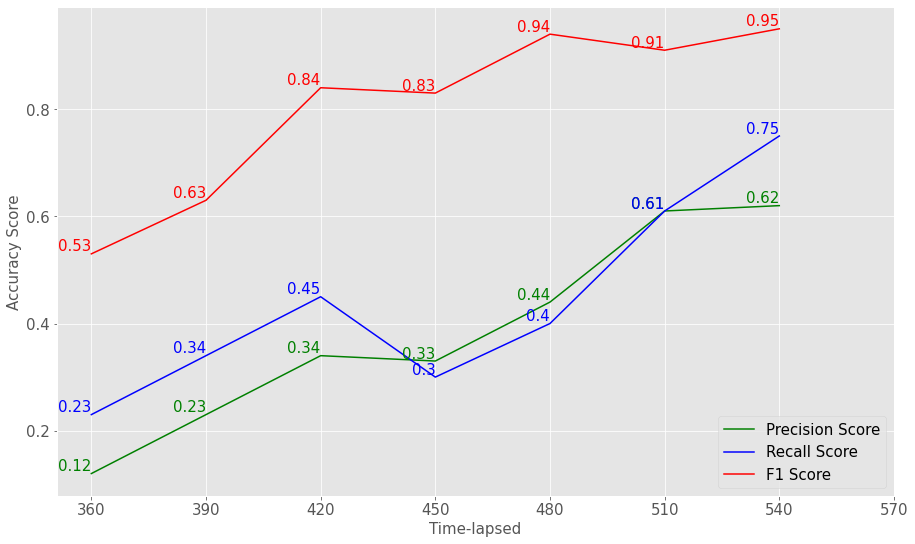

In [46]:
simulation_result_path = 'F:\\twitter_data\\givenchy\\pickle\\simulation_result_6_hour.csv'
save_img_path = 'F:\\twitter_data\\givenchy\\pickle\\simulation_result_6_hour.png'
plot_accuracy(simulation_result_path, save_img_path)